In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statistics
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.neighbors import KNeighborsClassifier

In [2]:
import sqlite3
conn = sqlite3.connect("/Users/ergangwang/Downloads/DSAH_Final/data_MIMIC/MIMIC.db")
admissions_df=pd.read_sql("""
    SELECT * FROM admissions
""",conn)

In [3]:
admissions_df['DISCHTIME'] = pd.to_datetime(admissions_df['DISCHTIME'])
admissions_df['ADMITTIME'] = pd.to_datetime(admissions_df['ADMITTIME'])
admissions_df['length_stay'] = (admissions_df['DISCHTIME'] - admissions_df['ADMITTIME']).dt.days
admissions_length = admissions_df[['SUBJECT_ID','HADM_ID','ADMITTIME','DISCHTIME','length_stay','HOSPITAL_EXPIRE_FLAG']]
patient_dead = admissions_length[(admissions_length.length_stay > 4) & (admissions_length.length_stay < 20) & (admissions_length.HOSPITAL_EXPIRE_FLAG ==1)]

In [4]:
# #HADM_ID_dead=patient_dead['HADM_ID'].to_list()
HADM_ID_dead_all = admissions_length[admissions_length.HOSPITAL_EXPIRE_FLAG==1]['HADM_ID'].to_list()
# len(HADM_ID_dead_all)

In [6]:
feature_table = pd.read_csv('/Users/ergangwang/Downloads/DSAH_Final/feature_with_label_all_48H.csv')
#HADM_ID_all = feature_table.HADM_ID.unique().tolist()
#len(HADM_ID_all)
#len(list(set(HADM_ID_dead)&set(HADM_ID_all)))

In [6]:
# idx=feature_table.groupby(['HADM_ID'],sort=False)['bin_num'].transform(max)==feature_table['bin_num']
# feature_table=feature_table[-idx]

In [7]:
# bool_max=feature_table.groupby(['HADM_ID'],sort=False)['bin_num'].transform(max)
# feature_table['label']=np.where((bool_max==feature_table['bin_num']) & (feature_table['HADM_ID'].isin(HADM_ID_dead_all)),1,0)
# feature_table.head(n=30)
# sum(feature_table['label'])

In [6]:
print("number of unique values of HADM_ID",feature_table['HADM_ID'].nunique())
unique_HAMD_ID=feature_table['HADM_ID'].unique()
print("number of HADM_ID that is dead")
L1=feature_table['HADM_ID'].unique().tolist()
len([i for i in L1 if i in HADM_ID_dead_all])

number of unique values of HADM_ID 54609
number of HADM_ID that is dead


5033

In [7]:
feature_table_df=feature_table.loc[:,feature_table.columns !="HADM_ID"]
feature_table_df=feature_table_df.loc[:,feature_table_df.columns !='bin_num']
feature_table_df=feature_table_df.loc[:,feature_table_df.columns !='label']
feature_label=feature_table_df.columns[0:,]
len(feature_label)
len(list(set(feature_label)))

335

In [10]:
# filter_col = [col for col in feature_table if col.startswith('abnormal')]
# filter_col
# abnormal_feature_table = feature_table[filter_col]
# abnormal_feature_table

### Logistic regression

In [20]:
from sklearn.linear_model import LogisticRegressionCV
#from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
model_matrix=feature_table.loc[:,feature_table.columns !="HADM_ID"]
model_matrix=model_matrix.loc[:,model_matrix.columns != "bin_num"]
model_matrix=model_matrix.loc[:,model_matrix.columns != "label"]
imr = SimpleImputer(missing_values = np.nan, strategy = 'mean')
imr = imr.fit(model_matrix.values)
model_matrix = imr.transform(model_matrix.values)
outcome=feature_table['label']


In [68]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test= train_test_split(
    model_matrix,outcome, test_size=0.2, random_state=42,stratify=outcome)
print(X_train,"xtest",X_test,"y_train",y_train,"y_test",y_test)

[[101.    0.6 526.  ...   0.    0.    0. ]
 [118.    0.8 185.  ...   0.    5.   64. ]
 [108.    1.  122.  ...   0.   34.  107. ]
 ...
 [107.    0.8 117.  ...   0.    4.   29. ]
 [103.    0.7 141.  ...   0.    8.   31. ]
 [103.    0.7  95.  ...   0.   14.   59. ]] xtest [[110.           0.7        118.         ...   0.           0.
    0.        ]
 [ 95.           5.8         81.         ...   0.          97.
  356.        ]
 [102.           1.5        150.84391767 ...   0.          10.
   27.        ]
 ...
 [107.           0.5        171.         ...   0.           0.
    0.        ]
 [112.           1.3        109.         ...   0.           3.
   26.        ]
 [124.           2.5        143.         ...   0.          38.
   37.        ]] y_train 211293    0
185428    0
111858    0
205099    0
218375    0
244998    0
142308    0
104104    0
272534    0
170019    0
263241    0
143654    0
80092     0
226619    0
186009    0
220931    0
182809    0
258025    0
243230    0
202033    0
23

In [73]:
print(len(X_train),len(y_train))

222228 222228


In [10]:
#feature normalization [scale from 0-1]
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

In [70]:
#feature normalization, using standard scaler, centered at 0
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

### L1 regularization to get sparse solutions

In [ ]:
#L1 regularization to get sparse solutions
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l1',C=1)
lr.fit(X_train_std, y_train)
print("training accuracy:",lr.score(X_train_std,y_train))
print('test accuracy:',lr.score(X_test_std,y_test))

/Users/ergangwang/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [ ]:
lr.intercept_
lr.coef_


In [ ]:
np.nonzero(lr.coef_)

### Sequential backward selection SBS

In [ ]:
#sequential backward selection SBS -> reduce the dimensionality of the initial feature subspace 
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
class SBS():
    def __init__(self, estimator, k_features,scoring=accuracy_score,test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
    def fit(self, X,y):
        X_train,X_test, y_train, y_test = \
                   train_test_split(X, y, test_size=self.test_size,
                                    random_state=self.random_state)
        dim=X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train,X_test, y_test, self.indices_)
        self.scores_ = [score]
        while dim > self.k_features:
            scores = []
            subsets = []
            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train,X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        return self
    def transform(self, X):
        return X[:, self.indices_]
    def _calc_score(self, X_train, y_train, X_test, y_test,indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [ ]:
#try the SBS implementation using the KNN classifier
knn = KNeighborsClassifier(n_neighbors=10)
sbs=SBS(knn,k_features=1)
sbs.fit(X_train_std,y_train)


In [ ]:
sbs.subsets_[10]

In [ ]:
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.show()

In [ ]:
#train the model with knn
knn.fit(X_train_std, y_train)
print("Training accuracy:", knn.score(X_train_std,y_train),'Test accuracy:',knn.score(X_test_std,y_test))

### assessing feature improtance with random forests


length of importances: 335 length of feature label 335 length of indices 335
 1) MAIN_drug                      0.025871
 2) Oxygen saturation_mean         0.017192
 3) Systolic blood pressure_mean   0.016081
 4) BASE_drug                      0.014719
 5) Platelets_mean                 0.014565
 6) White blood cell count_mean    0.014545
 7) White blood cell count_min     0.014357
 8) White blood cell count_max     0.014339
 9) Glascow coma scale motor response_mean 0.014151
10) Platelets_max                  0.014088
11) Mean blood pressure_mean       0.013882
12) Glucose_min                    0.013750
13) Platelets_min                  0.013731
14) Glucose_mean                   0.013697
15) Glascow coma scale eye opening_mean 0.013389
16) Oxygen saturation_min          0.013288
17) Glucose_max                    0.013275
18) Sodium_mean                    0.013002
19) Heart Rate_mean                0.012946
20) diag_count                     0.012938
21) Respiratory rate_mean     

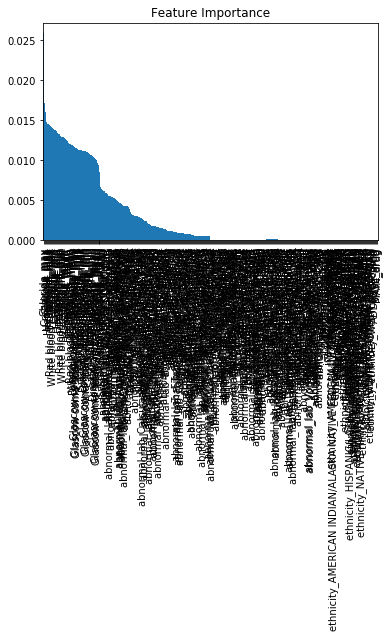

In [12]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=500, random_state=1)
forest.fit(X_train_std,y_train)
importances = forest.feature_importances_
indices=np.argsort(importances)[::-1]
print("length of importances:",len(importances),"length of feature label",len(feature_label),"length of indices",len(indices))
for f in range(X_train.shape[1]):
    print ("%2d) %-*s %f" % (f+1,30, feature_label[indices[f]],importances[indices[f]]))
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]),importances[indices],align='center')
plt.xticks(range(X_train.shape[1]),feature_label,rotation=90)
plt.xlim([-1,X_train_std.shape[1]])
# plt.tight_layout()
plt.show()

In [ ]:
model_matrix.shape

### Feature Extraction using PCA

In [ ]:
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print('\nEigenvalues \n%s' % eigen_vals)

In [ ]:
tot = sum(eigen_vals)
var_exp = [(i/tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
plt.bar(range(0,335), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(0,335), cum_var_exp, where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal Component Index')
plt.legend(loc='best')
plt.show()

In [ ]:
len(cum_var_exp)

In [ ]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [ ]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

In [ ]:
X_train_std[0].dot(w)

In [ ]:
X_train_pca = X_train_std.dot(w)
X_train_pca

In [ ]:
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0],X_train_pca[y_train==l, 1],c=c, label=l, marker=m)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()


PCA does not yield anything meaningful

### PCA with scikit-learn

In [ ]:
from matplotlib.colors import ListedColormap

In [ ]:
def plot_decision_regions(X,y,classifier,resolution=0.02):
    markers=('s','x','o','^','v')
    colors=('red','blue','lightgreen','gray','cyan')
    cmap=ListedColormap(colors[:len(np.unique(y))])
    x1_min, x1_max=X[:,0].min()-1,X[:,0].max()+1
    x2_min, x2_max=X[:,1].min()-1,X[:,1].max()+1
    xx1,xx2=np.meshgrid(np.arange(x1_min,x1_max,resolution),
                       np.arange(x2_min,x2_max,resolution))
    Z=classifier.predict(np.array([xx1.ravel(),xx2.ravel()]).T)
    Z=Z.reshape(xx1.shape)
    plt.contourf(xx1,xx2,Z,alpha=0.4,cmap=cmap)
    plt.xlim(xx1.min(),xx1.max())
    plt.ylim(xx2.min(),xx2.max())
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl,0],
                   y=X[y==cl,1],
                   alpha=0.6,c=cmap(idx),edgecolor='black',marker=markers[idx],label=cl)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
lr=LogisticRegression()
X_train_pca=pca.fit_transform(X_train_std)
X_test_pca=pca.transform(X_test_std)
lr.fit(X_train_pca, y_train)
plot_decision_regions(X_train_pca,y_train,classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

### Kernel PCA

In [ ]:
# from sklearn.decomposition import KernelPCA
# kpca = KernelPCA(kernel="rbf",fit_inverse_transform=True, gamma=10)
# X_kpca=kpca.fit_transform(X_train_std)
# X_back= kpca.inverse_transform(X_kpca)

# reds = y ==0
# blues = y ==1
# plt.scatter(X_kpca[reds,0],X_kpca[reds,1],c="red",s=20,edgecolor='k')
# plt.scatter(X_kpca[blues,0],X_kpca[blues,1],c="blue",s=20,edgecolor='k')

In [ ]:
y_train

### reshaping the feature table

### Combining transformers and estimators in a pipeline

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression 
from sklearn.pipeline import make_pipeline
pipe_lr=make_pipeline(StandardScaler(),PCA(n_components=2),LogisticRegression(random_state=1))
pipe_lr.fit(X_train_std, y_train)
y_pred=pipe_lr.predict(X_test)
print("test accuracy: %.3f" % pipe_lr.score(X_test_std,y_test))

NameError: name 'X_train_std' is not defined

### K-fold cross validation

In [3]:
from sklearn.linear_model import LogisticRegressionCV
#from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
feature_table = pd.read_csv('/Users/ergangwang/Downloads/DSAH_Final/feature_with_label_all_48H.csv')
model_matrix=feature_table.loc[:,feature_table.columns !="HADM_ID"]
model_matrix=model_matrix.loc[:,model_matrix.columns != "bin_num"]
model_matrix=model_matrix.loc[:,model_matrix.columns != "label"]
imr = SimpleImputer(missing_values = np.nan, strategy = 'mean')
imr = imr.fit(model_matrix.values)
model_matrix = imr.transform(model_matrix.values)
outcome=np.asarray(feature_table['label'])

In [4]:
X_train, X_test, y_train, y_test=train_test_split(model_matrix,outcome,stratify=outcome,  test_size=0.2, random_state=0)

In [20]:
y_train

array([0, 0, 0, ..., 1, 0, 1])

In [24]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
scores=[]
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(model_matrix,outcome)
pipe_lr = make_pipeline(StandardScaler(),PCA(n_components=2),LogisticRegression(solver='liblinear',random_state=1))
for train_index, test_index in skf.split(X_train,y_train):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
    y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]
    X_train_cv_std = stdsc.fit_transform(X_train_cv)
    X_test_cv_std = stdsc.transform(X_test_cv)
    pipe_lr.fit(X_train_cv_std,y_train_cv)
    score=pipe_lr.score(X_test_cv_std,y_test_cv)
    scores.append(score)
    print('Fold: %2d, Class dist.: %s, Acc: %.3f' % (k+1,np.bincount(y_train[train]), score))
print('\nCV accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

Fold: 10, Class dist.: [405   5], Acc: 0.981
Fold: 10, Class dist.: [405   5], Acc: 0.981
Fold: 10, Class dist.: [405   5], Acc: 0.981
Fold: 10, Class dist.: [405   5], Acc: 0.981
Fold: 10, Class dist.: [405   5], Acc: 0.981
Fold: 10, Class dist.: [405   5], Acc: 0.981
Fold: 10, Class dist.: [405   5], Acc: 0.982
Fold: 10, Class dist.: [405   5], Acc: 0.982
Fold: 10, Class dist.: [405   5], Acc: 0.982
Fold: 10, Class dist.: [405   5], Acc: 0.981


In [25]:
#use the scikit-learn k-fold cross-validation scorer
from sklearn.model_selection import cross_val_score
scores=cross_val_score(estimator=pipe_lr,X=X_train,y=y_train,cv=10,n_jobs=-1)
print('CV accuracy scores: %s' % scores)

CV accuracy scores: [0.98132649 0.9812815  0.98137065 0.98146065 0.98119066 0.98123566
 0.98159482 0.98159482 0.98168482 0.98123481]


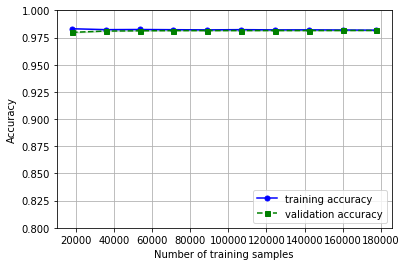

In [29]:
#diagnosing bias and variance problems with learning curves
from sklearn.model_selection import learning_curve
pipe_lr = make_pipeline(StandardScaler(),LogisticRegression(solver='lbfgs',penalty='l2', random_state=1))
train_sizes, train_scores, test_scores =learning_curve(estimator=pipe_lr,X=X_train,y=y_train,
                                                       train_sizes=np.linspace(0.1, 1.0, 10),cv=5, n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean,color='blue', marker='o',markersize=5, label='training accuracy')
plt.fill_between(train_sizes,train_mean + train_std,train_mean - train_std,alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,color='green', linestyle='--',marker='s', markersize=5,label='validation accuracy')
plt.fill_between(train_sizes,test_mean + test_std,test_mean - test_std,alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

In [ ]:
from sklearn.model_selection import validation_curve
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(estimator=pipe_lr,X=X_train,y=y_train,param_name='logisticregression__C',
                param_range=param_range,cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean,color='blue', marker='o',markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean + train_std,train_mean - train_std, alpha=0.15,color='blue')
plt.plot(param_range, test_mean,color='green', linestyle='--',marker='s', markersize=5,label='validation accuracy')
plt.fill_between(param_range,test_mean + test_std,test_mean - test_std,alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.03])
plt.show()

In [38]:
#tuning hyperparameters via grid search
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
pipe_svc=make_pipeline(StandardScaler(),SVC(random_state=1))
param_range = [0.0001,0.001,0.01,0.1,1,10,100,1000]
param_grid=[{'svc__C':param_range,'svc__kernel':['linear']},{'svc__C':param_range,
                        'svc__gamma':param_range,'svc__kernel':['rbf']}]
gs = GridSearchCV(estimator=pipe_svc,param_grid=param_grid,scoring='accuracy',
                 cv=10,n_jobs=-1)
gs=gs.fit(X_train,y_train)
print(gs.best_score_)
print(gs.best_params_)

KeyboardInterrupt: 

In [37]:
pipe_svc.get_params().keys()

dict_keys(['memory', 'steps', 'standardscaler', 'svc', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'svc__C', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 'svc__decision_function_shape', 'svc__degree', 'svc__gamma', 'svc__kernel', 'svc__max_iter', 'svc__probability', 'svc__random_state', 'svc__shrinking', 'svc__tol', 'svc__verbose'])

In [ ]:
clf=gs.best_estimator_
clf.fit(X_train_y_train)
print("Test accuracy: %.3f" % clf.score(X_test,y_test))

### nested cross-validation

In [ ]:
# compare SVM model to a simple decision tree classifier and a svm
gs=GridSearchCV(estimator=pipe_svc,param_grid=param_grid,scoring='accuracy',cv=2)
scores=cross_val_score(gs,X_train,y_train,scoring='accuracy',cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

pipe_dtc=make_pipeline(StandardScaler(),DecisionTreeClassifier(random_state=1))
gs=GridSearchCV(estimator=pipe_dtc,param_grid=[{'decisiontreeclassifier__max_depth':[1,2,3,4,5,6,7,None]}],scoring='accuracy',cv=2)
scores=cross_val_score(gs,X_train,y_train,scoring='accuracy',cv=5)
print("CV accuracy: %.3f +/- %.3f" % (np.mean(scores),np.std(scores)))

CV accuracy: 0.982 +/- 0.000


In [9]:
pipe_dtc.get_params().keys()

dict_keys(['memory', 'steps', 'standardscaler', 'decisiontreeclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'decisiontreeclassifier__class_weight', 'decisiontreeclassifier__criterion', 'decisiontreeclassifier__max_depth', 'decisiontreeclassifier__max_features', 'decisiontreeclassifier__max_leaf_nodes', 'decisiontreeclassifier__min_impurity_decrease', 'decisiontreeclassifier__min_impurity_split', 'decisiontreeclassifier__min_samples_leaf', 'decisiontreeclassifier__min_samples_split', 'decisiontreeclassifier__min_weight_fraction_leaf', 'decisiontreeclassifier__presort', 'decisiontreeclassifier__random_state', 'decisiontreeclassifier__splitter'])

### look at different performance evaluation metrics

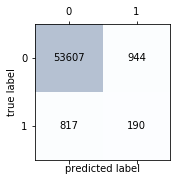

In [13]:
from sklearn.metrics import confusion_matrix
pipe_dtc.fit(X_train,y_train)
y_pred=pipe_dtc.predict(X_test)
confmat=confusion_matrix(y_true=y_test,y_pred=y_pred)
fig,ax=plt.subplots(figsize=(2.5,2.5))
ax.matshow(confmat, cmap=plt.cm.Blues,alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j,y=i,s=confmat[i,j],va='center',ha='center')
plt.xlabel('predicted label')
plt.ylabel("true label")
plt.show()

### supervised data compression linear discriminant analysis

In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.datasets import make_regression
X_train, y_train = make_regression(noise=4, random_state=0)
reg = LassoCV(cv=5, random_state=0).fit(X_train, y_train)
reg.score(X_train, y_train) 



In [ ]:
#clf = LogisticRegressionCV(cv=5, random_state=0,multi_class='multinomial').fit(X_train, y_train)

In [1]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/''machine-learning-databases''/breast-cancer-wisconsin/wdbc.data',header=None)

In [2]:
from sklearn.preprocessing import LabelEncoder
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =train_test_split(X, y,test_size=0.20,stratify=y,random_state=1)

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
pipe_lr = make_pipeline(StandardScaler(),PCA(n_components=2),LogisticRegression(random_state=1))
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.956


/Users/ergangwang/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [5]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10,random_state=1).split(X_train,y_train)
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %2d, Class dist.: %s, Acc: %.3f' % (k+1,np.bincount(y_train[train]), score))

Fold:  1, Class dist.: [256 153], Acc: 0.935
Fold:  2, Class dist.: [256 153], Acc: 0.935
Fold:  3, Class dist.: [256 153], Acc: 0.957
Fold:  4, Class dist.: [256 153], Acc: 0.957
Fold:  5, Class dist.: [256 153], Acc: 0.935
Fold:  6, Class dist.: [257 153], Acc: 0.956
Fold:  7, Class dist.: [257 153], Acc: 0.978
Fold:  8, Class dist.: [257 153], Acc: 0.933
Fold:  9, Class dist.: [257 153], Acc: 0.956
Fold: 10, Class dist.: [257 153], Acc: 0.956


/Users/ergangwang/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ergangwang/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ergangwang/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ergangwang/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ergangwang/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/lo

In [6]:
y_train

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,